# Why are so many employees leaving? and Who exactly are these employees?

** First let's do some exploratory analysis on our data! **

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

hr_data = pd.read_csv('HR_comma_sep.csv')
hr_data['dept'] = hr_data['sales']
hr_data.drop(['sales'], axis = 1, inplace = True)
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,dept
0,0.38,0.53,2,157,3,0,1,0,low,sales
1,0.80,0.86,5,262,6,0,1,0,medium,sales
2,0.11,0.88,7,272,4,0,1,0,medium,sales
3,0.72,0.87,5,223,5,0,1,0,low,sales
4,0.37,0.52,2,159,3,0,1,0,low,sales


In order to make the data easier to understand I will add a column that gives the *salary* column a numerical value as follows:

Salary Description | Salary Value 
--- | ---
low | 40,000
medium | 60,000
high | 80,000
    

In [188]:
salary_dict = {'low': 40000, 'medium': 60000, 'high': 80000}
hr_data['salary_estimate'] = hr_data['salary'].map(salary_dict)

Furthermore, I am interested in performing analysis on this data in the following groups:

- Good performers who left the company
- Good performers who stayed with the company
- Average/Below Average performers who left the company
- Average/Below A performers who stayed with the company

I think it will be interesting to see the similarities and differences between these groups.

** What is an Above Average performer?**

*I will define an above average performer as anyone who's performance evaluation was at least 1 standard deviation above the mean(Top 84th percentile). Everyone else is average or below average.*

In [189]:
eval_mean = hr_data['last_evaluation'].mean()
eval_std = np.std(hr_data['last_evaluation'])
hr_data['performance(standard units)'] = (hr_data['last_evaluation']- eval_mean)/eval_std

def performance_label(row):
    performance = row['performance(standard units)']
    if performance >=1:
        result = 'Above Average'
    else:
        result = 'Average or Below'
    return(result)
hr_data['performance label'] = hr_data.apply(performance_label, axis = 1)

left_dict = {1: 'left', 0: 'stayed'}

hr_data['left(as_string)'] = (hr_data['left'].map(left_dict))

Next we'll take a look at the average values for numerical columns in our data as an initial look into the potential problem.

In [190]:
columns = (hr_data.columns)
num_columns = (hr_data._get_numeric_data().columns)

sep_hr_data = hr_data
sep_hr_data['Performance cluster'] = sep_hr_data['left(as_string)'] + ' : ' + sep_hr_data['performance label']

sep_hr_pivot = sep_hr_data.pivot_table(index= (['Performance cluster']), values =num_columns, aggfunc=np.mean)
sep_hr_pivot.transpose()

Performance cluster,left : Above Average,left : Average or Below,stayed : Above Average,stayed : Average or Below
Work_accident,0.038425,0.050988,0.172983,0.175504
average_montly_hours,254.862632,187.898024,202.358003,198.254872
last_evaluation,0.947666,0.623660,0.941899,0.660180
left,1.000000,1.000000,0.000000,0.000000
number_project,5.179635,3.310672,3.825680,3.777137
performance(standard units),1.352882,-0.540078,1.319193,-0.326718
promotion_last_5years,0.000961,0.007115,0.025858,0.026347
salary_estimate,48107.588857,48371.541502,52492.197949,53147.523136
satisfaction_level,0.538069,0.399787,0.680013,0.663585
time_spend_company,4.716619,3.530830,3.380740,3.379858


The values that immediately jump out to me are the average_montly_hours, number_project, salary_estimate, and promotion_last_5years, so I will expore the more in depth.

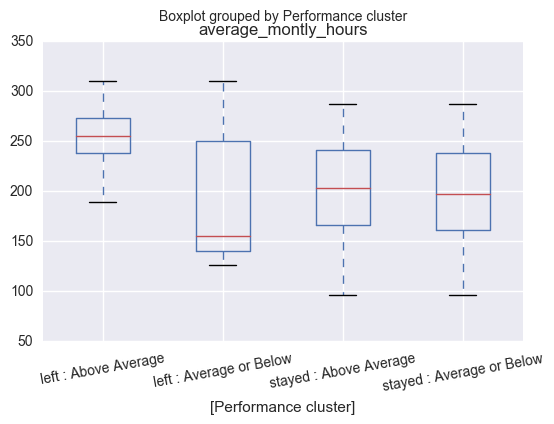

In [191]:
sep_hr_data[['Performance cluster', 'average_montly_hours']].boxplot(by = 'Performance cluster')
plt.xticks(rotation = 10)
plt.show()

Good performing employees who left the company were averaging 255 hours per month, which equates to about **12 hours per day(based on a 250 days in a year)**.
All other groups were averaging **9 to 10 hours per day.**

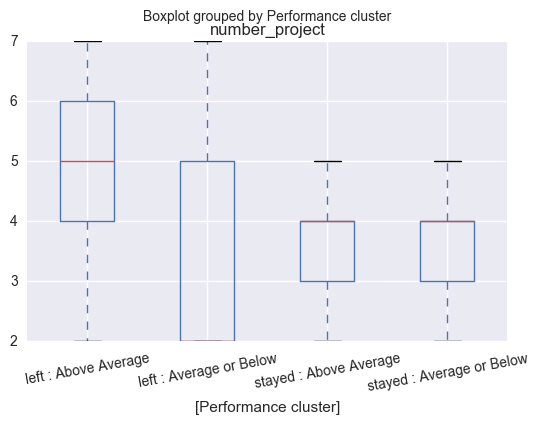

In [192]:
sep_hr_data[['Performance cluster', 'number_project']].boxplot(by = 'Performance cluster')
plt.xticks(rotation = 10)
plt.show()

Similarly, the Above Average performers who left, were more likely to take on projects, which most likely correlates with number of work hours.

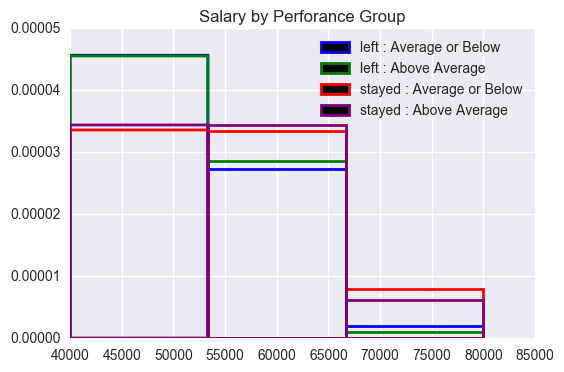

In [193]:
colors = ['blue', 'green', 'red', 'purple']
for i, category in enumerate(sep_hr_data['Performance cluster'].unique()):
    hist_bin = sep_hr_data['salary_estimate'][sep_hr_data['Performance cluster'] == category]
    plt.hist(hist_bin,3, alpha=1, label=category, normed = True, linewidth=2, facecolor = 'none', edgecolor = colors[i])
plt.legend(loc='upper right')
plt.title('Salary by Perforance Group')
plt.show()

Above, this histogram shows us that a high percentage of those who left the company fell into the low income category. Those who stayed with the company were more likely to fall into the medium to high income category.

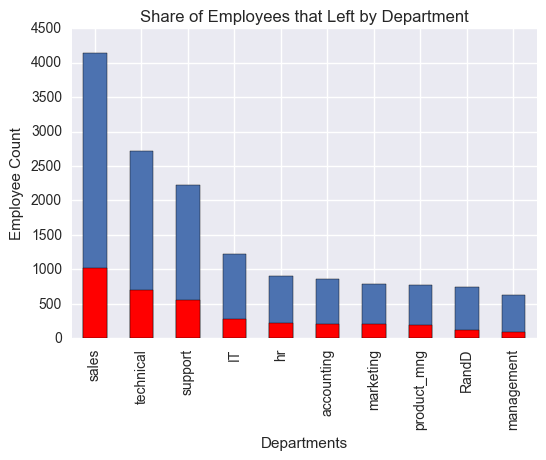

Percentage of employees that left by department 

 IT             22.25
RandD          15.37
accounting     26.60
hr             29.09
management     14.44
marketing      23.66
product_mng    21.95
sales          24.49
support        24.90
technical      25.62
Name: dept, dtype: float64


In [194]:
left_data = sep_hr_data[sep_hr_data.left == 1]
sep_hr_data.dept.value_counts().plot(kind='bar')
left_data.dept.value_counts().plot(kind='bar', color = 'red')
plt.title('Share of Employees that Left by Department')
plt.xlabel('Departments')
plt.ylabel('Employee Count')
plt.show()
percent_left = round(left_data.dept.value_counts()/ sep_hr_data.dept.value_counts() * 100, 2)
print('Percentage of employees that left by department \n\n', percent_left)

- It also looks like HR and Accounting have employees that are most likely to leave.

**Next, I want to take a look at the correlations between certain features for Above Average vs Average/Below Average performs who left the company.**

## Correlations for Above Average Performers

In [195]:
columns = ['left','average_montly_hours', 'number_project','time_spend_company']

aa_sep_hr_data = sep_hr_data[(sep_hr_data['performance label']=='Above Average')]
ab_sep_hr_data = sep_hr_data[(sep_hr_data['performance label']!='Above Average')]
average_corr = ab_sep_hr_data.corr()
above_average_corr = aa_sep_hr_data.corr().loc[columns].transpose()
below_average_corr = ab_sep_hr_data.corr().loc[columns].transpose()
above_average_corr

,left,average_montly_hours,number_project,time_spend_company
satisfaction_level,-0.242301,-0.255929,-0.471205,-0.077654
last_evaluation,0.076439,-0.025307,-0.044458,0.049442
number_project,0.537256,0.366696,1.000000,0.211145
average_montly_hours,0.521604,1.000000,0.366696,0.187693
time_spend_company,0.418430,0.187693,0.211145,1.000000
Work_accident,-0.185972,-0.086005,-0.071028,-0.082317
left,1.000000,0.521604,0.537256,0.418430
promotion_last_5years,-0.087218,0.003030,-0.029398,0.014741
salary_estimate,-0.167982,-0.048164,-0.108459,-0.018586
performance(standard units),0.076439,-0.025307,-0.044458,0.049442


## Correlations for Below Average Performers

In [196]:
below_average_corr

,left,average_montly_hours,number_project,time_spend_company
satisfaction_level,-0.450204,0.037969,-0.059429,-0.116547
last_evaluation,-0.110281,0.334712,0.348881,0.083434
number_project,-0.157442,0.402044,1.000000,0.171130
average_montly_hours,-0.085878,1.000000,0.402044,0.088013
time_spend_company,0.043103,0.088013,0.171130,1.000000
Work_accident,-0.144042,0.013827,0.017399,0.028289
left,1.000000,-0.085878,-0.157442,0.043103
promotion_last_5years,-0.053722,-0.002285,0.002441,0.083528
salary_estimate,-0.152379,0.017117,0.033399,0.072166
performance(standard units),-0.110281,0.334712,0.348881,0.083434


### Key Points 

- For Above Average Performers:
    - Leaving the company is highly correlated with working many hours, taking on many projects and time spent with the company
    - Monthly hours and number of projects is highly correlated with a high level of dissatisfaction
    - Time spent with the company also seemed to correlate with number of projects taken on
    - At the same time, there was no correlation between number of projects and promotions or higher performance evaluations
    
    
- For Average/Below Average Performers:
    -  Leaving the company is highly correlated satisfaction level. No other metric is as correlated
    -  For this group, as opposed to the Above Average group, Monthly hours and number of projects is highly correlated with higher performance reviews.

## Thoughts....

**Above Average Performers** seem to be overworked. Because they are above average performers, they may be given many difficult projects by their managers, that they may not be fully prepared for, resulting in a working overtime and high levels of stress and dissastisfaction. Also, they may be getting average performance reviews for these particular projects, resulting in little to no salary increases, or promotions. As stated earlier, time seems to be highly correlated with leaving the company. Due to lack of praise at work, and lack of pay increases, time may be the biggest factor in leaving for these valueable employees.


**Average/Below Average Performers** do not seem to be overworked. These employees seem to be leaving the company because they are just very unsatisfied. It does seem that these employees are getting higher performance reviews based on the number of projects that they are taking on. I believe that these employees are given less projects, due to past underperformace, and are also given easier projects. This is resulting is higher performance reviews when these 'easy' projects are completed, but are not accompanied by promotions or salary increases.

## Actions to be taken

- Require managers to 'check-in' with their employees more often, to make sure that their concerns are being voiced
    - Managers should reassess goals more aften
        - Provide more attainable goals
- More team projects, so there is less stress on any individual employee
    - Increased potential for better overall performance
    - At the same time, many underperformers will learn the practices of the overperformers
- Promote empoyees based on team performances
    - There are many employees that are not getting promoted, who should be
        - Team performance evaluations will allow more employees to get recognized/promoted
- Implementation of a flexible 8 hour work day, with a strict 10 hour limit
    - Prevents burnout and promotes good work/life balanace
- Implementation of more worker recognition programs
    - To make employees feel appreciated a less likely to leave

Upon starting this project, I believed that these two groups were leaving the company for different reasons. Now, I understand they were actually leaving for the same reasons, but from different underlying factors.

## Next, I will apply machine learning techniques, in order to understand which algorithms work best in predicting which employees will leave next.

In [197]:
hr_data1 = hr_data.drop(['performance label', 'left(as_string)', 'Performance cluster',\
                         'salary_estimate', 'satisfaction_level', 'performance(standard units)', 'Work_accident'], axis = 1)
dummies = pd.get_dummies(hr_data1[['dept', 'salary']])
hr_data1 = pd.concat([hr_data1, dummies], axis=1)
hr_data1.drop(['dept', 'salary'], axis = 1, inplace = True)

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict, KFold

cols = hr_data1.columns
cols = cols.drop("left")
features = hr_data1[cols]
target = hr_data1["left"]

lr = LogisticRegression()
kf = KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

In [199]:
hr_data1.head()

,last_evaluation,number_project,average_montly_hours,time_spend_company,left,promotion_last_5years,dept_IT,dept_RandD,dept_accounting,dept_hr,dept_management,dept_marketing,dept_product_mng,dept_sales,dept_support,dept_technical,salary_high,salary_low,salary_medium
0,0.53,2,157,3,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.86,5,262,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.88,7,272,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.87,5,223,5,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.52,2,159,3,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [200]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

## First: Logistic Regression

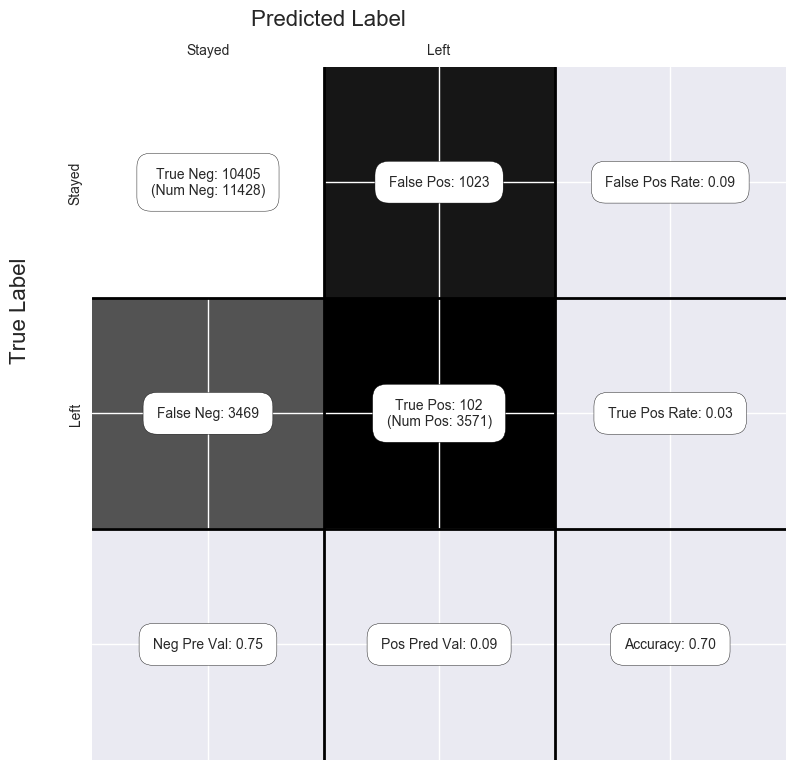

In [201]:
C = confusion_matrix(hr_data1.left,predictions)
show_confusion_matrix(C, ['Stayed', 'Left'])

- As we can see, this Logistic Regression model is only yielding a 70% accuracy.
- False Postive Rate is low at just 9%, which is good.
- True Positive Rate is also low at 3%, which is bad.
- This model is not very good at predicting who is likely to leave.

## Lets try a Random Forest

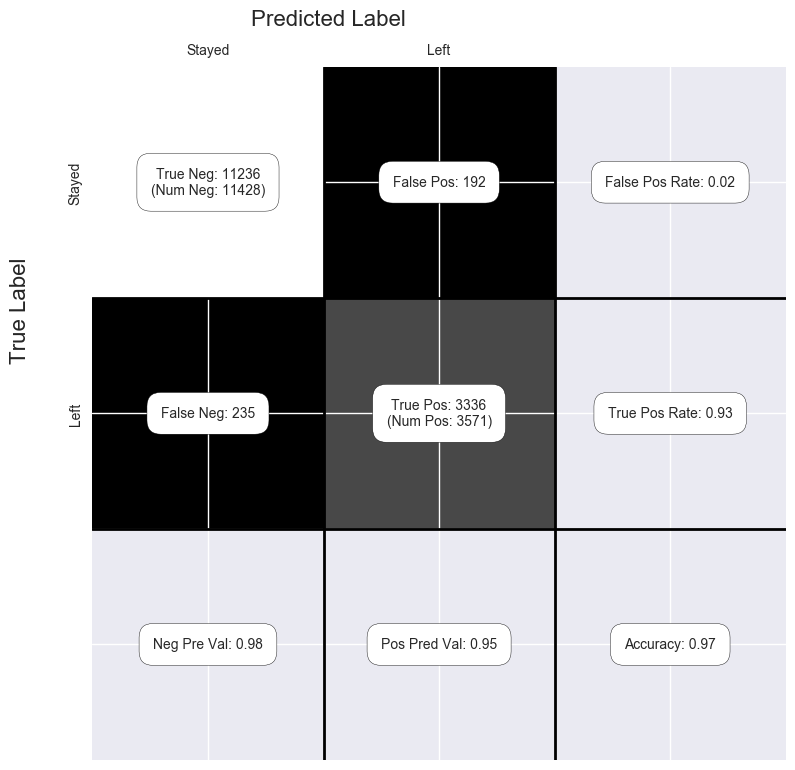

In [202]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight="balanced", random_state=1)
predictions1 = cross_val_predict(rf, features, target, cv=kf)
predictions1 = pd.Series(predictions1)

C1 = confusion_matrix(hr_data1.left,predictions1)
show_confusion_matrix(C1, ['Stayed', 'Left'])

- A Random Forest Model is a better model with a 97% accuracy
- It it able to maintain a low False Positive Rate at 2%
- True Positive Rate is high at 93%
- Overall, this model does a better job is prediciting whihc employees will leave next.